# The main evaluation script

## Loading data

In [1]:
from datasets import load_dataset, Dataset # Make sure you have already installed `datasets` library
from functools import partial
from models import get_supported_models
from asr_model_evaluator import ASRModelEvaluator

In [ ]:
dataset = load_dataset("mozilla-foundation/common_voice_17_0", "ru", split="test",
                       streaming=True, token="<HF_TOKEN>", # MCV17 is a gated dataset, therefore HF_TOKEN is required
                       trust_remote_code=True)

dataset = dataset.select_columns(["audio", "sentence"]).rename_column("sentence", "transcription")
# Make sure to use `transcription` column for the transcription of the audio


# Here is a trick to create a small dataset without downloading its full version :)
def generator_from_iterable(iterable):
    yield from iterable

dataset = Dataset.from_generator(
    generator=partial(generator_from_iterable, dataset.shuffle(seed=42).take(100)), # Take 100 random samples
    features=dataset.features,
)

Leaving example dataset since the actual hse_lectures_dataset is not publicly available

In [3]:
# dataset = load_dataset("VDK/hse_lectures_dataset_private", split="test", token="<HF_TOKEN>")

## Perform the evaluation

In [4]:
evaluator = ASRModelEvaluator(metric="wer") # Supported metrics are `wer` and `cer`, computing Word or Character Error Rate, respectively

In [5]:
models = get_supported_models()

print(*models, sep='\n') # Show all supported models

SeamlessM4T Medium
SeamlessM4T Large-v1
SeamlessM4T Large-v2
MMS-1B FL102
MMS-1B L1107
MMS-1B All
Whisper Tiny
Whisper Base
Whisper Small
Whisper Medium
Whisper Large-v1
Whisper Large-v2
Whisper Large-v3
Whisper Turbo
NVIDIA STT Multilingual FastConformer Hybrid Transducer-CTC Large P&C
NVIDIA STT Ru Conformer-CTC Large
NVIDIA FastConformer-Hybrid Large (ru)
NVIDIA FastConformer-Hybrid Large (kk-ru)
GigaAM CTC-1
GigaAM RNNT-1
GigaAM CTC-2
GigaAM RNNT-2
T-One


In [6]:
wer_list = evaluator.evaluate(
    models=models,
    data=dataset,
    use_text_normalization=True, # Whether to normalize text before computing the metric or not
    use_device="cuda", # Change to `cpu` in case CUDA supporting GPU is not available
    verbose=None, # Whether to print the progress of the evaluation or not (set to `True` to enable all progress bars)
)

Evaluating SeamlessM4T Medium
wer = 0.20512820512820512
Evaluating SeamlessM4T Large-v1
wer = 0.16727716727716727
Evaluating SeamlessM4T Large-v2


Instantiating a decoder SeamlessM4Tv2Attention without passing `layer_idx` is not recommended and will lead to errors during the forward call, if caching is used. Please make sure to provide a `layer_idx` when creating this class.


wer = 0.13553113553113552
Evaluating MMS-1B FL102
wer = 0.4053724053724054
Evaluating MMS-1B L1107
wer = 0.4590964590964591
Evaluating MMS-1B All
wer = 0.2796092796092796
Evaluating Whisper Tiny
wer = 0.608058608058608
Evaluating Whisper Base
wer = 0.452991452991453
Evaluating Whisper Small
wer = 0.24297924297924298
Evaluating Whisper Medium
wer = 0.1684981684981685
Evaluating Whisper Large-v1
wer = 0.15018315018315018
Evaluating Whisper Large-v2
wer = 0.11843711843711843
Evaluating Whisper Large-v3
wer = 0.09768009768009768
Evaluating Whisper Turbo
wer = 0.10989010989010989
Evaluating NVIDIA STT Multilingual FastConformer Hybrid Transducer-CTC Large P&C
wer = 0.21001221001221002
Evaluating NVIDIA STT Ru Conformer-CTC Large
wer = 0.10989010989010989
Evaluating NVIDIA FastConformer-Hybrid Large (ru)
wer = 0.09645909645909646
Evaluating NVIDIA FastConformer-Hybrid Large (kk-ru)
wer = 0.10622710622710622
Evaluating GigaAM CTC-1
wer = 0.27350427350427353
Evaluating GigaAM RNNT-1
wer = 0.23

## Check the results

Create plain table with the results

In [7]:
max_width = max(len(model_name) for model_name in models)

for model_name, wer in sorted(zip(models, wer_list), key=lambda pair: pair[1]):
    print(f"{model_name.ljust(max_width)} -> {wer:.5f}")

GigaAM RNNT-2                                                         -> 0.05006
GigaAM CTC-2                                                          -> 0.05617
NVIDIA FastConformer-Hybrid Large (ru)                                -> 0.09646
Whisper Large-v3                                                      -> 0.09768
NVIDIA FastConformer-Hybrid Large (kk-ru)                             -> 0.10623
T-One                                                                 -> 0.10623
Whisper Turbo                                                         -> 0.10989
NVIDIA STT Ru Conformer-CTC Large                                     -> 0.10989
Whisper Large-v2                                                      -> 0.11844
SeamlessM4T Large-v2                                                  -> 0.13553
Whisper Large-v1                                                      -> 0.15018
SeamlessM4T Large-v1                                                  -> 0.16728
Whisper Medium              

Draw bar chart with evaluation results

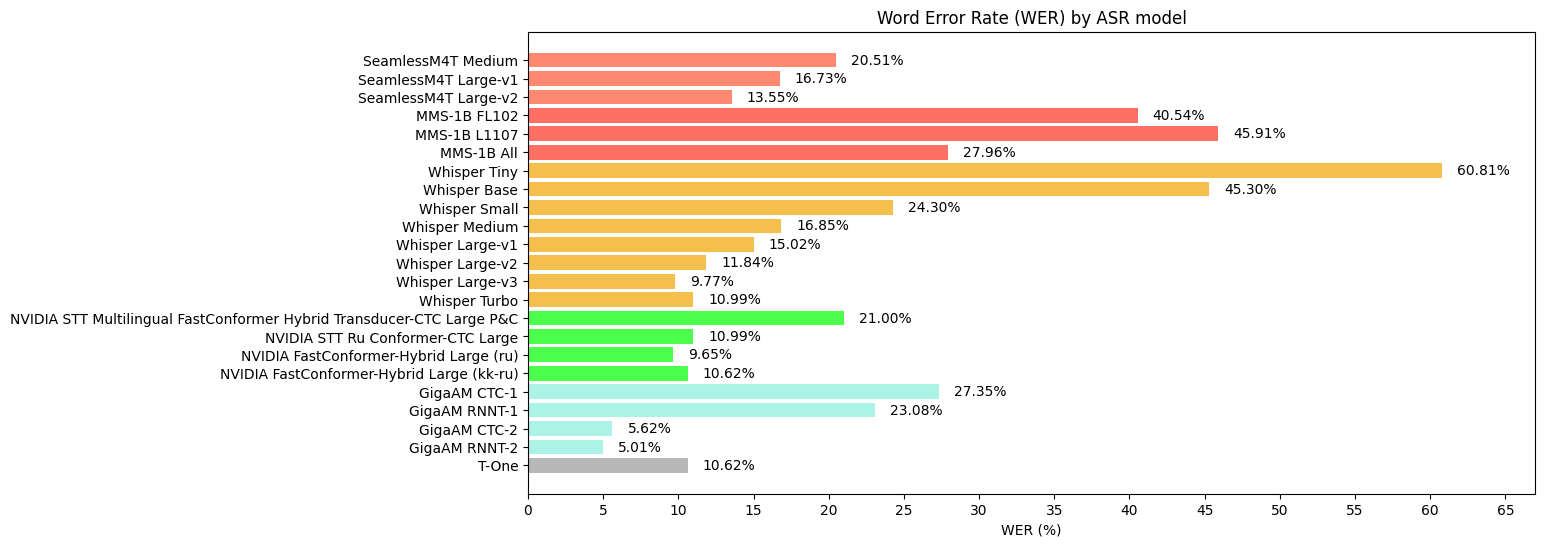

In [8]:
import matplotlib.pyplot as plt
import numpy as np

color_map = {
    "SeamlessM4T": "#FF5733",
    "MMS": "#FF3322",
    "NVIDIA": "#00FF00",
    "Whisper": "#F0A500",
    "GigaAM": "#88EEDD",
} # Just example colors

bar_colors = []
for model in models:
    if "SeamlessM4T" in model:
        bar_colors.append(color_map["SeamlessM4T"])
    elif "MMS" in model:
        bar_colors.append(color_map["MMS"])
    elif "NVIDIA" in model:
        bar_colors.append(color_map["NVIDIA"])
    elif "Whisper" in model:
        bar_colors.append(color_map["Whisper"])
    elif "GigaAM" in model:
        bar_colors.append(color_map["GigaAM"])
    else:
        bar_colors.append("#999999")

wer = np.asarray(wer_list) * 100

fig, ax = plt.subplots(figsize=(13, 6))
y_pos = np.arange(len(models))
ax.barh(y_pos, wer, color=bar_colors, alpha=0.7)

ax.set_title("Word Error Rate (WER) by ASR model")
ax.set_xlabel("WER (%)")
ax.set_xlim(0, int(np.max(wer)) + 7)
ax.set_xticks(np.arange(0, int(np.max(wer)) + 7, 5))
ax.set_yticks(y_pos)
ax.set_yticklabels(models)

for i, v in enumerate(wer):
    ax.text(v + 1, i, f"{v:.2f}%", va="center")

plt.gca().invert_yaxis()
plt.show();